In [1]:
%matplotlib widget

In [6]:
from cryosparc.tools import CryoSPARC
import json
import numpy as np
from pathlib import Path
import matplotlib as mpl
from matplotlib import pyplot as plt
# scipy is an additional dependency
from scipy.interpolate import splprep, splev

def make_2d_hist(x_component, y_component, pts = None, ax = None, norm = "linear", plot_range = [[-1, 1],[-1, 1]], **kwargs):
    # use our own norm argument instead of **kwargs b/c handling of string args to norm in ax.hexbin
    # is broken in the version of MPL shipped with CS
    if norm == "log":
        normalizer = mpl.colors.LogNorm()
    else:
        normalizer = None
    if norm not in ["log", "linear", None]:
        print(f"Warning: normalizer '{norm}' not implemented. Using linear scale.")
    
    if "norm" in kwargs:
        del kwargs["norm"]

    if ax is None:
        ax = plt.gca()

    heatmap = ax.hist2d(
        x_component,
        y_component,
        bins = 75,
        norm = normalizer,
        range = plot_range,
        **kwargs
    )

    if pts is not None:
        ax.plot(
            pts[:, 0],
            pts[:, 1],
            "-o",
            color = "black",
            linewidth = 3,
            markersize = 6
        )

    ax.set_xlim(*plot_range[0])
    ax.set_ylim(*plot_range[1])
    ax.set_aspect(1)

    return heatmap

In [7]:
with open(Path('~/instance-info.json').expanduser(), 'r') as f:
    instance_info = json.load(f)

cs = CryoSPARC(**instance_info)
assert cs.test_connection()

project_uid = "P328"
workspace_uid = "W1"
job_uid = "J22"
selected_dimensions = [0,1]

project = cs.find_project(project_uid)
workspace = project.find_workspace(workspace_uid)
latent_job = project.find_job(job_uid)
particles = latent_job.load_output("particles")
x_component = particles[f"components_mode_{selected_dimensions[0]}/value"]
y_component = particles[f"components_mode_{selected_dimensions[1]}/value"]

rng = np.random.default_rng()
jitter_x = rng.random(size = x_component.shape) * 0.02
jitter_y = rng.random(size = y_component.shape) * 0.02

Connection succeeded to CryoSPARC command_core at http://cryoem0.sbi:40002
Connection succeeded to CryoSPARC command_vis at http://cryoem0.sbi:40003
Connection succeeded to CryoSPARC command_rtp at http://cryoem0.sbi:40005


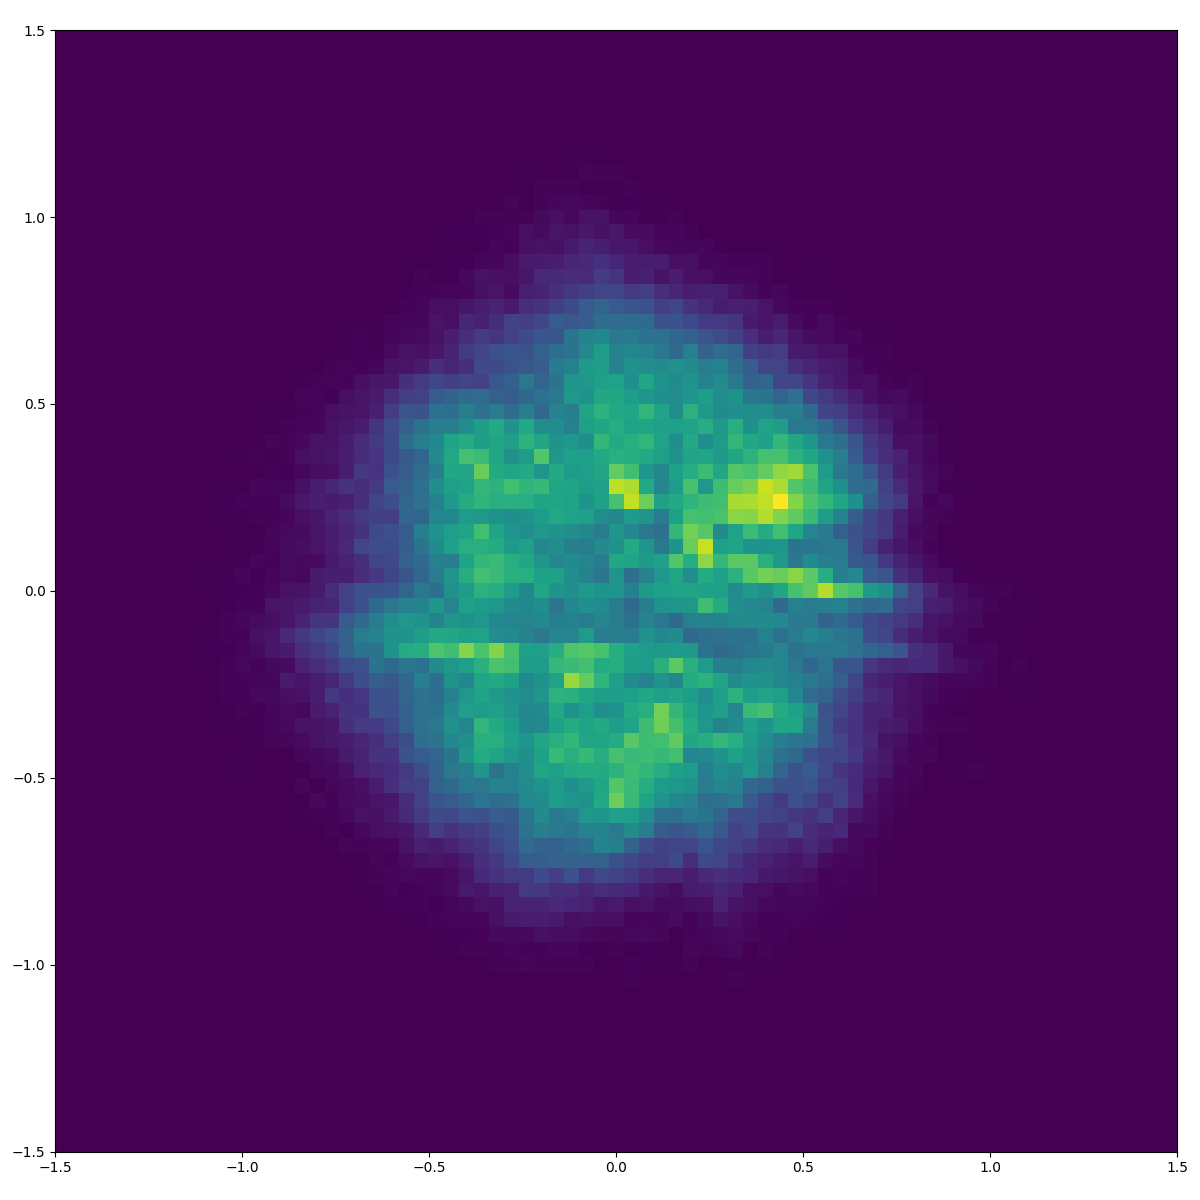

In [8]:
pts = []
plot_range = [[-1.5, 1.5], [-1.5, 1.5]]

fig = plt.figure(figsize=(12, 12), layout = "tight")
make_2d_hist(x_component + jitter_x, y_component + jitter_y, plot_range = plot_range)

def onclick(event):
    fig.clf()
    pts.append([event.xdata, event.ydata])
    apts = np.array(pts)
    make_2d_hist(x_component + jitter_x, y_component + jitter_y, pts = apts, plot_range = plot_range)

cid = plt.gcf().canvas.mpl_connect("button_press_event", onclick)

In [9]:
latent_pts = np.array(pts)
for pt in latent_pts:
    print(f"{pt[0]:5.2f}, {pt[1]:5.2f}")

 0.48,  0.31
 0.05,  0.27
 0.48,  0.01
 0.41, -0.31
 0.05, -0.46
-0.40, -0.17
-0.34,  0.31


Text(0, 0.5, 'Coordinate 1')

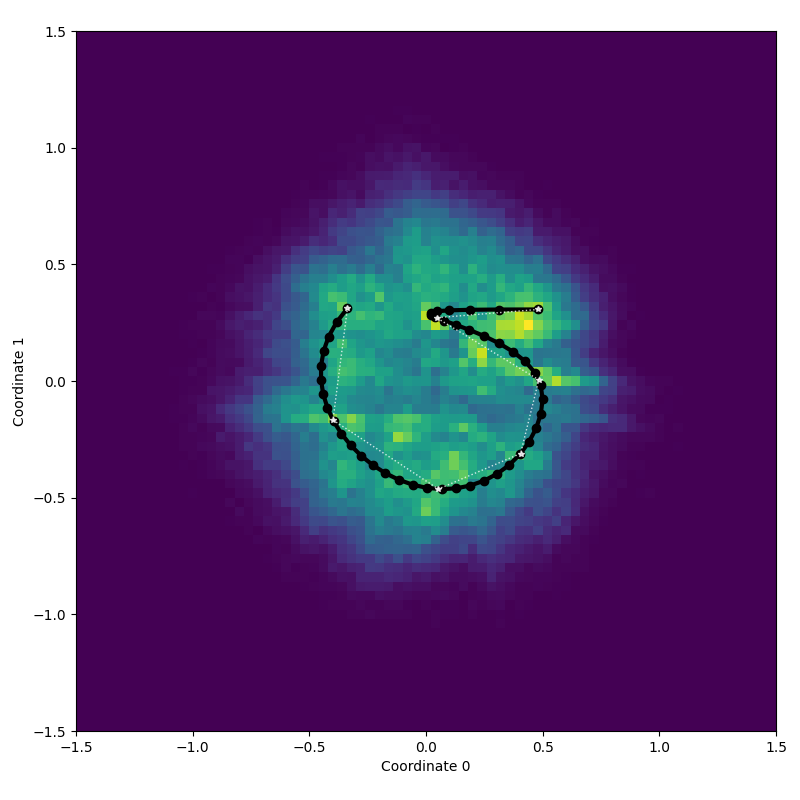

In [10]:
# increasing the smoothing factor smooths out the generated points
# generally 0 is smooth enough
smoothing = 0.0
# set how many points you want here
num_samples = 45

spl, u = splprep([latent_pts[:, 0], latent_pts[:, 1]], s = smoothing)
smooth_points = np.array(splev(np.linspace(u[0], u[-1], num = num_samples), spl)).T

fig, ax = plt.subplots(figsize = (8, 8), layout = "tight")
_ = make_2d_hist(x_component + jitter_x, y_component + jitter_y, pts = np.array(smooth_points), ax = ax, plot_range = plot_range)

ax.plot(
    latent_pts[:, 0],
    latent_pts[:, 1],
    ":*",
    color = "white",
    alpha = 0.8,
    linewidth = 1,
    markersize = 4
)

ax.set_xlabel(f"Coordinate {selected_dimensions[0]}")
ax.set_ylabel(f"Coordinate {selected_dimensions[1]}")

In [11]:
num_components = len([x for x in particles.fields() if 'components_mode' in x and "value" in x])
slot_spec = [
    {"dtype": "components", "prefix": f"components_mode_{k}", "required": True}
    for k in range(num_components)
]

# if use_smooth_points is True, we use the smoothed points (black above)
# if use_smooth_points if False, we use exactly the points we clicked (white above)
use_smooth_points = True
if use_smooth_points:
    pts = smooth_points
else:
    pts = latent_pts


latent_job = project.create_external_job(workspace_uid, f"Custom Latents ({'smooth' if use_smooth_points else 'raw'})")
latent_job.connect("particles", job_uid, "particles", slots=slot_spec)
latents_dset = latent_job.add_output(
    type="particle",
    name="latents",
    slots=slot_spec,
    title="Latents",
    alloc=len(pts),
)
for k in range(num_components):
    latents_dset[f"components_mode_{k}/component"] = k
    try:
        latents_dset[f"components_mode_{k}/value"] = pts[:, selected_dimensions.index(k)]
    except ValueError:
        latents_dset[f"components_mode_{k}/value"] = 0

with latent_job.run():
    latent_job.save_output("latents", latents_dset)
    latent_job.log_plot(fig, "Latents")

# create and hook up a generate job
generate_job = workspace.create_job(
    "flex_generate",
    connections = {
        "flex_model": (job_uid, "flex_model"),
        "latents": (latent_job.doc["uid"], "latents")
    }
)